# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

Мы научимся обрабатывать пропуски в данных для количественных (числовых) и категориальных признаков и масштабировать данные. Также мы научимся преобразовывать категориальные признаки в числовые.

### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [1]:
import micropip
await micropip.install('seaborn')  # Установка seaborn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

Используем данные из соревнования [House Prices: Advanced Regression Techniques.](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [5]:
# Будем использовать только обучающую выборку
data = pd.read_csv('data/houseprices.csv', sep=",")

In [6]:
# размер набора данных
data.shape

(1460, 81)

In [7]:
# типы колонок
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [8]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [9]:
# Первые 5 строк датасета
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 1460


# Обработка пропусков в данных

## Простые стратегии - удаление или заполнение нулями

Удаление колонок, содержащих пустые значения
`res = data.dropna(axis=1, how='any')`

Удаление строк, содержащих пустые значения
`res = data.dropna(axis=0, how='any')`

[Документация](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

**Удаление может производиться для группы строк или колонок.**

In [11]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((1460, 81), (1460, 62))

In [12]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((1460, 81), (0, 81))

In [13]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000


## "Внедрение значений" - импьютация (imputation)

### Обработка пропусков в числовых данных

In [15]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка LotFrontage. Тип данных float64. Количество пустых значений 259, 17.74%.
Колонка MasVnrArea. Тип данных float64. Количество пустых значений 8, 0.55%.
Колонка GarageYrBlt. Тип данных float64. Количество пустых значений 81, 5.55%.


In [17]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,LotFrontage,MasVnrArea,GarageYrBlt
0,65.0,196.0,2003.0
1,80.0,0.0,1976.0
2,68.0,162.0,2001.0
3,60.0,0.0,1998.0
4,84.0,350.0,2000.0
...,...,...,...
1455,62.0,0.0,1999.0
1456,85.0,119.0,1978.0
1457,66.0,0.0,1941.0
1458,68.0,0.0,1950.0


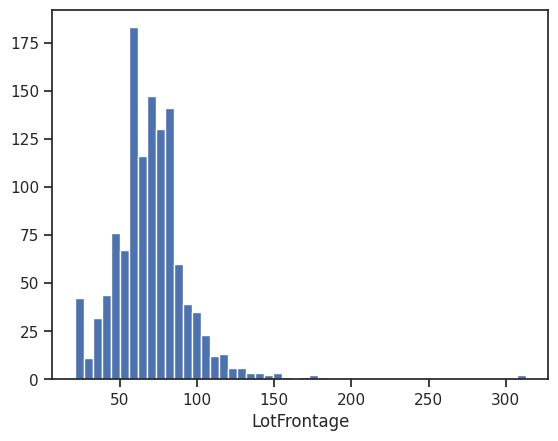

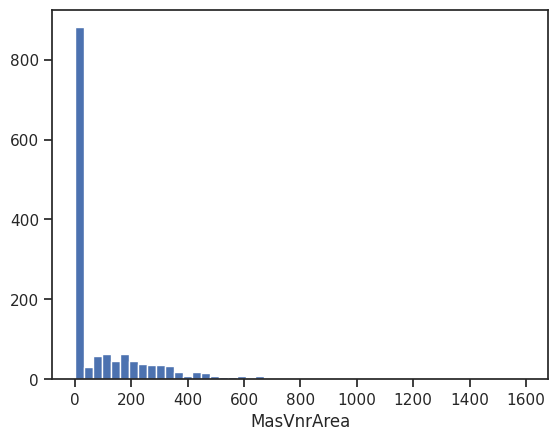

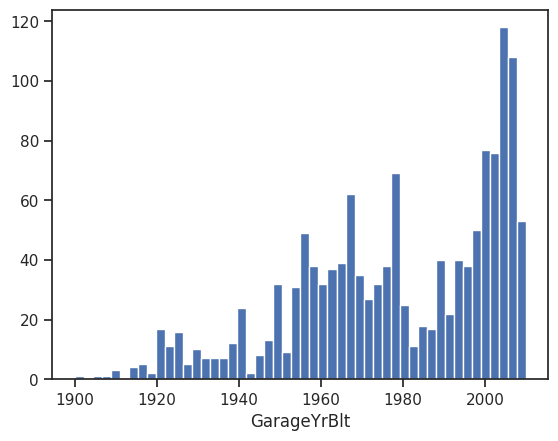

In [18]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html

In [19]:
data_num_MasVnrArea = data_num[['MasVnrArea']]
data_num_MasVnrArea.head()

,MasVnrArea
0,196.0
1,0.0
2,162.0
3,0.0
4,350.0


In [20]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [21]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_MasVnrArea)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [22]:
strategies=['mean', 'median', 'most_frequent']

In [23]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_MasVnrArea)
    return data_num_imp[mask_missing_values_only]

In [24]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([103.68526171, 103.68526171, 103.68526171, 103.68526171,
        103.68526171, 103.68526171, 103.68526171, 103.68526171]))

In [25]:
strategies[1], test_num_impute(strategies[1])

('median', array([0., 0., 0., 0., 0., 0., 0., 0.]))

In [26]:
strategies[2], test_num_impute(strategies[2])

('most_frequent', array([0., 0., 0., 0., 0., 0., 0., 0.]))

In [27]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [28]:
data[['GarageYrBlt']].describe()

,GarageYrBlt
count,1379.000000
mean,1978.506164
std,24.689725
min,1900.000000
25%,1961.000000
50%,1980.000000
75%,2002.000000
max,2010.000000


In [29]:
test_num_impute_col(data, 'GarageYrBlt', strategies[0])

('GarageYrBlt',
 'mean',
 81,
 np.float64(1978.5061638868744),
 np.float64(1978.5061638868744))

In [30]:
test_num_impute_col(data, 'GarageYrBlt', strategies[1])

('GarageYrBlt', 'median', 81, np.float64(1980.0), np.float64(1980.0))

In [31]:
test_num_impute_col(data, 'GarageYrBlt', strategies[2])

('GarageYrBlt', 'most_frequent', 81, np.float64(2005.0), np.float64(2005.0))

### Обработка пропусков в категориальных данных

In [32]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Alley. Тип данных object. Количество пустых значений 1369, 93.77%.
Колонка MasVnrType. Тип данных object. Количество пустых значений 872, 59.73%.
Колонка BsmtQual. Тип данных object. Количество пустых значений 37, 2.53%.
Колонка BsmtCond. Тип данных object. Количество пустых значений 37, 2.53%.
Колонка BsmtExposure. Тип данных object. Количество пустых значений 38, 2.6%.
Колонка BsmtFinType1. Тип данных object. Количество пустых значений 37, 2.53%.
Колонка BsmtFinType2. Тип данных object. Количество пустых значений 38, 2.6%.
Колонка Electrical. Тип данных object. Количество пустых значений 1, 0.07%.
Колонка FireplaceQu. Тип данных object. Количество пустых значений 690, 47.26%.
Колонка GarageType. Тип данных object. Количество пустых значений 81, 5.55%.
Колонка GarageFinish. Тип данных object. Количество пустых значений 81, 5.55%.
Колонка GarageQual. Тип данных object. Количество пустых значений 81, 5.55%.
Колонка GarageCond. Тип данных object. Количество пустых значений 81, 5.

**Какие из этих колонок Вы бы выбрали или не выбрали для построения модели?**

Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [33]:
cat_temp_data = data[['MasVnrType']]
cat_temp_data.head()

,MasVnrType
0,BrkFace
1,NaN
2,BrkFace
3,NaN
4,BrkFace


In [34]:
cat_temp_data['MasVnrType'].unique()

array(['BrkFace', nan, 'Stone', 'BrkCmn'], dtype=object)

In [35]:
cat_temp_data[cat_temp_data['MasVnrType'].isnull()].shape

(872, 1)

In [36]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['BrkFace'],
       ['BrkFace'],
       ['BrkFace'],
       ...,
       ['BrkFace'],
       ['BrkFace'],
       ['BrkFace']], dtype=object)

In [37]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['BrkCmn', 'BrkFace', 'Stone'], dtype=object)

In [38]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['BrkFace'],
       ['NA'],
       ['BrkFace'],
       ...,
       ['NA'],
       ['NA'],
       ['NA']], dtype=object)

In [39]:
np.unique(data_imp3)

array(['BrkCmn', 'BrkFace', 'NA', 'Stone'], dtype=object)

In [40]:
data_imp3[data_imp3=='NA'].size

872

# Преобразование категориальных признаков в числовые

In [41]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,BrkFace
1,BrkFace
2,BrkFace
3,BrkFace
4,BrkFace
...,...
1455,BrkFace
1456,Stone
1457,BrkFace
1458,BrkFace


## Кодирование категорий целочисленными значениями - [label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [42]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [43]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [44]:
cat_enc['c1'].unique()

array(['BrkFace', 'Stone', 'BrkCmn'], dtype=object)

In [45]:
np.unique(cat_enc_le)

array([0, 1, 2])

In [47]:
le.inverse_transform([0, 1, 2])

array(['BrkCmn', 'BrkFace', 'Stone'], dtype=object)

## Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [48]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [49]:
cat_enc.shape

(1460, 1)

In [50]:
cat_enc_ohe.shape

(1460, 3)

In [51]:
cat_enc_ohe

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1460 stored elements and shape (1460, 3)>

In [52]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [53]:
cat_enc.head(10)

,c1
0,BrkFace
1,BrkFace
2,BrkFace
3,BrkFace
4,BrkFace
5,BrkFace
6,Stone
7,Stone
8,BrkFace
9,BrkFace


## [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [62]:
pd.get_dummies(cat_enc).head()

,c1_BrkCmn,c1_BrkFace,c1_Stone
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False


In [63]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,MasVnrType_nan
0,False,True,False,False
1,False,False,False,True
2,False,True,False,False
3,False,False,False,True
4,False,True,False,False


# Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы, но это неверно. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины. В этом разделе рассматривается только масштабирование.

Если признаки лежат в различных диапазонах, то необходимо их нормализовать. Как правило, применяют два подхода:
- MinMax масштабирование:
$$ x_{новый} = \frac{x_{старый} - min(X)}{max(X)-min(X)} $$

В этом случае значения лежат в диапазоне от 0 до 1.
- Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0):
$$ x_{новый} = \frac{x_{старый} - AVG(X) }{\sigma(X)} $$

В этом случае большинство значений попадает в диапазон от -3 до 3.

где $X$ - матрица объект-признак, $AVG(X)$ - среднее значение, $\sigma$ - среднеквадратичное отклонение.

In [56]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [57]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['SalePrice']])

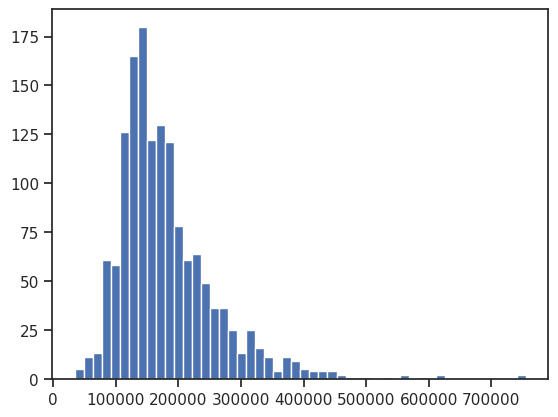

In [58]:
plt.hist(data['SalePrice'], 50)
plt.show()

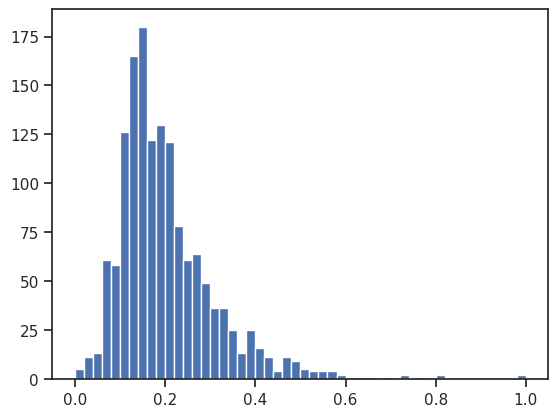

In [59]:
plt.hist(sc1_data, 50)
plt.show()

## Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0) - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [60]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['SalePrice']])

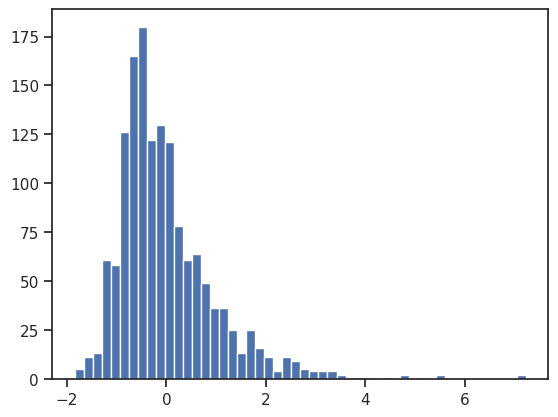

In [61]:
plt.hist(sc2_data, 50)
plt.show()

# Дополнительные источники
- [Руководство scikit-learn по предобработке данных](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Kaggle Data Cleaning Challenge: Handling missing values (упражнения с пояснениями по обработке пропущенных значений и масштабированию признаков)](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values)
- [Краткое руководство по категориальным признакам](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c)